<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

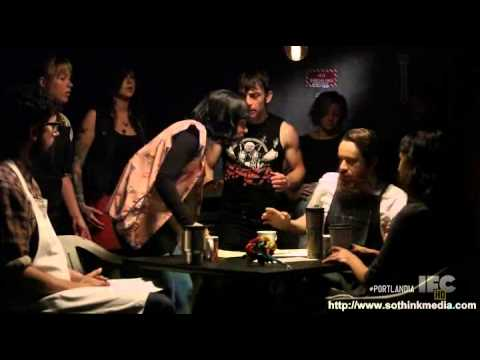

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'/Users/Samantha/Documents/Lambda/Unit4/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [14]:
# tokenize full_review_text

import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

tokenizer = Tokenizer(nlp.vocab)

# make a new column of the df that consists of the token lists
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

shops['tokens'] = tokens

shops.head()

,coffee_shop_name,full_review_text,star_rating,tokens
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,"[ , 11/25/2016, 1, check-in, Love, love, loved..."
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,"[ , 12/2/2016, Listed, in, Date, Night:, Austi..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,"[ , 11/30/2016, 1, check-in, Listed, in, Brunc..."
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,"[ , 11/25/2016, Very, cool, decor!, Good, drin..."
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,"[ , 12/3/2016, 1, check-in, They, are, located..."


In [15]:
# use the count function from lecture to break down tokens

from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')
    
    
wc = count(shops['tokens'])

wc.head()
# got some silliness like whitespace counting as a token, no stop word removal yet

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
1,the,6520,27779,1.0,0.034334,0.034334,0.856092
38,and,6804,25748,2.0,0.031824,0.066157,0.893382
35,,7616,22606,3.0,0.027940,0.094097,1.000000
3,a,6181,22085,4.0,0.027296,0.121394,0.811581
23,I,5469,19780,5.0,0.024447,0.145841,0.718093


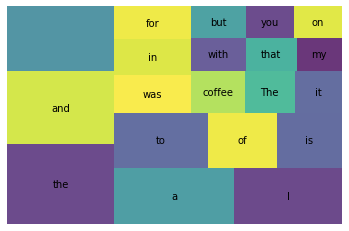

In [16]:
# visualize current top tokens

import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [18]:
# replace tokens column with BETTER tokens
# uses only default spacy stop words

tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())
            
    tokens.append(doc_tokens)

shops['tokens'] = tokens

shops.head()

,coffee_shop_name,full_review_text,star_rating,tokens
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,"[ , 11/25/2016, 1, check-in, love, love, loved..."
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,"[ , 12/2/2016, listed, date, night:, austin,, ..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,"[ , 11/30/2016, 1, check-in, listed, brunch, s..."
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,"[ , 11/25/2016, cool, decor!, good, drinks, ni..."
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,"[ , 12/3/2016, 1, check-in, located, northcros..."


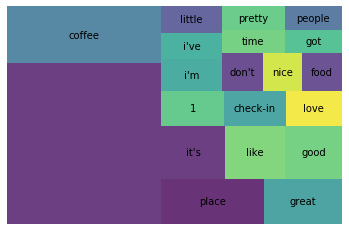

In [20]:
# viz of better tokens

wc = count(shops['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

# still got a whitespace token :(

In [24]:
# improve set of stop words

STOP_WORDS = nlp.Defaults.stop_words.union([' ',"i've", "i'm", "it's", 'got', '1', "check-in", '-'])


In [25]:
# replace tokens again

tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

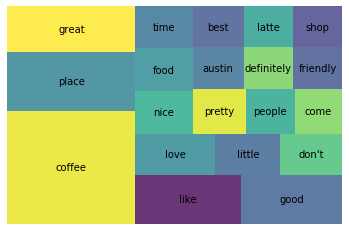

In [26]:
# viz of better BETTER tokens

wc = count(shops['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [ ]:
wc.tail(20)
# not as funny as the amazon reviews, sadly

In [31]:
# there aren't any obvious issues with lemmas cropping up in the top tokens
# but I'm doing lemmatization anyway
# had to go back and control case

# function from class
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.text.lower() not in STOP_WORDS) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_.lower())
    
    return lemmas

shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)

shops.head()

,coffee_shop_name,full_review_text,star_rating,tokens,lemmas
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,"[11/25/2016, love, love, loved, atmosphere!, c...","[11/25/2016, check, love, love, love, atmosphe..."
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,"[12/2/2016, listed, date, night:, austin,, amb...","[12/2/2016, list, date, night, austin, ambianc..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,"[11/30/2016, listed, brunch, spots, loved, ecl...","[11/30/2016, check, list, brunch, spots, love,..."
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,"[11/25/2016, cool, decor!, good, drinks, nice,...","[11/25/2016, cool, decor, good, drink, nice, s..."
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,"[12/3/2016, located, northcross, mall, shoppin...","[12/3/2016, check, locate, northcross, mall, s..."


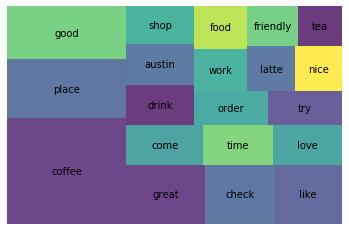

In [32]:
# viz of lemmas

wc = count(shops['lemmas'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [33]:
wc.tail(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
16362,beast,1,1,16367.0,0.000003,0.999948,0.000131
16364,ridick,1,1,16368.0,0.000003,0.999951,0.000131
16363,divorce,1,1,16369.0,0.000003,0.999954,0.000131
16361,buuuuuut,1,1,16370.0,0.000003,0.999956,0.000131
16368,holla,1,1,16371.0,0.000003,0.999959,0.000131
16369,shelby,1,1,16372.0,0.000003,0.999962,0.000131
16372,foodwise,1,1,16373.0,0.000003,0.999965,0.000131
16371,foodgasm,1,1,16374.0,0.000003,0.999967,0.000131
16374,lentil,1,1,16375.0,0.000003,0.999970,0.000131
16370,mum,1,1,16376.0,0.000003,0.999973,0.000131


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [34]:
# first, let's change the ratings to numbers

shops['star_rating'].value_counts()

 5.0 star rating     3780
 4.0 star rating     2360
 3.0 star rating      738
 2.0 star rating      460
 1.0 star rating      278
Name: star_rating, dtype: int64

In [41]:
shops['star_rating'] = shops['star_rating'].apply(lambda s: s.strip('.0 star rating'))

shops['star_rating'].value_counts()

5    3780
4    2360
3     738
2     460
1     278
Name: star_rating, dtype: int64

In [43]:
shops['star_rating'] = shops['star_rating'].apply(int)

shops['star_rating'].describe()

count    7616.000000
mean        4.169118
std         1.065311
min         1.000000
25%         4.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: star_rating, dtype: float64

In [77]:
cafe_dict = {}

for shop in shops['coffee_shop_name'].value_counts().index:
    df = shops[shops['coffee_shop_name'] == shop]
    avg = df['star_rating'].mean()
    cafe_dict[shop] = avg
    
cafe_dict

{'Epoch Coffee ': 3.8125,
 'Halcyon ': 3.82,
 'The Factory - Cafe With a Soul ': 4.360655737704918,
 'Venezia Italian Gelato ': 4.81,
 'Houndstooth Coffee ': 4.175,
 'Caffé Medici ': 4.174825174825175,
 'Apanas Coffee & Beer ': 4.580882352941177,
 'Mary’s Cafe ': 4.36,
 'Corona Coffee ': 4.53,
 'Kick Butt Coffee Music & Booze ': 3.72,
 'The Hideout Coffeehouse ': 3.91,
 'Stinson’s ': 3.81,
 'Dolce Neve ': 4.64,
 'Strange Brew, Austin Coffee ': 3.6,
 'Flightpath Coffeehouse ': 4.23,
 'Caffe Medici ': 4.04,
 'Tea Haus ': 4.11,
 'Vintage Heart Coffee ': 4.17,
 'Alta’s Cafe ': 3.93,
 'Cream Whiskers ': 3.93,
 'Summer Moon Coffee Bar ': 4.09,
 'Genuine Joe ': 3.95,
 'Bennu Coffee ': 4.13,
 'Patika ': 4.35,
 'Quack’s 43rd Street Bakery ': 4.19,
 'Summermoon Coffee Bar ': 4.53,
 'Cuvée Coffee Bar ': 3.82,
 'Cenote ': 4.04,
 'Thunderbird Coffee ': 3.97,
 'Hot Mama’s Cafe ': 4.27,
 'Cherrywood Coffeehouse ': 3.96,
 'Russell’s Bakery ': 3.89,
 'Arturo’s Underground Cafe ': 4.3,
 'Café Crème ': 4

In [95]:
sum([])/len([])

ZeroDivisionError: division by zero

In [102]:
# function to compute the average rating of all reviews containing a given lemma

def avg_score(word):
    score_list = []
    for i in range(len(shops)):
        if word in shops.iloc[i].lemmas:
            score_list.append(shops.iloc[i].star_rating)
    if score_list:
        return sum(score_list)/len(score_list)
    return 0

avg_score('love')

4.448105436573312

In [ ]:
lemma_dict = {}

for i in range(len(shops)):
    for word in shops.iloc[i].lemmas:
        if word not in lemma_dict:
            lemma_dict[word] = avg_score(word)
            
lemma_dict

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

